In [2]:
import pandas as pd
import sqlite3
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

## Data Preprocessing

In [3]:
conn = sqlite3.connect(r'C:\Users\Owner\dev\algobetting\infra\data\db\algobetting.db')

df = pd.read_sql_query("""
                        SELECT DISTINCT
                            f.*,
                            ms.summary_goals as goals
                        FROM 
                            team_all_features_365_005 f
                        JOIN
                            fbref_match_summary_v2 ms
                                ON ms.match_url = f.match_url
                                AND ms.team = f.team
                        WHERE 
                            f.team_rolling_summary_minutes IS NOT NULL
                       """, conn)

df

,match_url,match_date,season,division,team,opp_team,is_home,gw,is_promoted?,is_early_season?,...,opp_team_rolling_conceded_defense_challenges,opp_team_rolling_conceded_defense_challenge_tackles_pct,opp_team_rolling_conceded_defense_challenges_lost,opp_team_rolling_conceded_defense_blocked_shots,opp_team_rolling_conceded_defense_blocked_passes,opp_team_rolling_conceded_defense_tackles_interceptions,opp_team_rolling_conceded_defense_clearances,opp_team_rolling_conceded_defense_errors,opp_team_rolling_conceded_keeper_psxg,goals
0,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25 00:00:00,2024-2025,Premier League,Tottenham,Brighton,1,38,0,0,...,18.309716,50.720617,8.796946,3.393454,7.020603,26.403010,27.177737,0.862971,1.299603,1.0
1,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25 00:00:00,2024-2025,Premier League,Brighton,Tottenham,0,38,0,0,...,19.336254,57.889854,7.949406,3.378971,9.378588,32.038948,23.558919,0.911136,1.805191,4.0
2,https://fbref.com/en/matches/1ff370e8/Bournemo...,2025-05-25 00:00:00,2024-2025,Premier League,Bournemouth,Leicester City,1,38,0,0,...,14.039872,53.893970,6.606014,2.506894,6.904780,22.901258,21.697324,0.636969,1.811285,2.0
3,https://fbref.com/en/matches/1ff370e8/Bournemo...,2025-05-25 00:00:00,2024-2025,Premier League,Leicester City,Bournemouth,0,38,1,0,...,14.891199,49.279905,7.520887,4.153870,6.746572,23.732322,26.770789,1.451179,1.460762,0.0
4,https://fbref.com/en/matches/36844e73/Newcastl...,2025-05-25 00:00:00,2024-2025,Premier League,Newcastle Utd,Everton,1,38,0,0,...,14.492786,53.064874,6.895930,2.600829,6.075265,24.063503,26.142993,0.567784,1.251694,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40661,https://fbref.com/en/matches/e8e75a75/Como-Cag...,2022-08-13 00:00:00,2022-2023,Serie B,Como,Cagliari,1,1,0,1,...,12.576303,47.905175,6.408071,3.518286,6.676135,21.826232,17.942850,0.219500,1.367898,1.0
40662,https://fbref.com/en/matches/e8e75a75/Como-Cag...,2022-08-13 00:00:00,2022-2023,Serie B,Cagliari,Como,0,1,0,1,...,15.017375,42.604852,8.589310,2.172112,6.611274,23.664988,14.871051,0.075024,1.541054,1.0
40663,https://fbref.com/en/matches/99979e25/Cittadel...,2022-08-13 00:00:00,2022-2023,Serie B,Cittadella,Pisa,1,1,0,1,...,14.804043,47.089937,7.713670,2.909231,6.588752,27.403947,19.741195,0.237578,1.160446,4.0
40664,https://fbref.com/en/matches/99979e25/Cittadel...,2022-08-13 00:00:00,2022-2023,Serie B,Pisa,Cittadella,0,1,0,1,...,11.574599,50.507986,5.815970,3.866474,9.173457,27.363966,20.635355,0.149176,0.957865,3.0


### Feature Engineering

## Model Training

In [4]:
X = df.drop(columns=["team", "opp_team", "goals", "match_url", "match_date"])
X = pd.get_dummies(X, columns=["season", "division"], drop_first=True)
y = df["goals"]

# Use matches after a certain date as test
cutoff_date = '2024-08-01'
df['match_date'] = pd.to_datetime(df['match_date'])

train_mask = df['match_date'] < cutoff_date
test_mask = df['match_date'] >= cutoff_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

# Create DMatrix objects BEFORE using them in eval_list
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'count:poisson',
    'max_depth': 7,
    'eta': 0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'eval_metric': 'poisson-nloglik'
}

num_rounds = 100
eval_list = [(dtrain, 'train'), (dtest, 'eval')]  # Now dtrain and dtest are defined

model = xgb.train(
    params, 
    dtrain, 
    num_rounds, 
    eval_list, 
    early_stopping_rounds=10,
    verbose_eval=10
)

# Make predictions
preds = model.predict(dtest)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-poisson-nloglik:1.50412	eval-poisson-nloglik:1.49473
[10]	train-poisson-nloglik:1.44097	eval-poisson-nloglik:1.45145
[20]	train-poisson-nloglik:1.41021	eval-poisson-nloglik:1.43831
[30]	train-poisson-nloglik:1.39053	eval-poisson-nloglik:1.43455
[40]	train-poisson-nloglik:1.37551	eval-poisson-nloglik:1.43337
[50]	train-poisson-nloglik:1.36269	eval-poisson-nloglik:1.43243
[60]	train-poisson-nloglik:1.35176	eval-poisson-nloglik:1.43324
[64]	train-poisson-nloglik:1.34759	eval-poisson-nloglik:1.43334
RMSE: 1.1210
MAE: 0.8841


In [5]:
# Get feature importance
importance = model.get_score(importance_type='gain')

# Convert to DataFrame for easier manipulation
importance_df = pd.DataFrame({'Feature': list(importance.keys()), 
                             'Importance': list(importance.values())})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Normalize to 0-100 scale
importance_df['Importance'] = 100 * importance_df['Importance'] / importance_df['Importance'].max()

# Display results
importance_df

,Feature,Importance
44,team_rolling_possession_passes_received,100.000000
18,team_rolling_summary_xg_assist,59.752078
16,team_rolling_summary_xg,47.815632
33,team_rolling_possession_touches_att_pen_area,46.594273
17,team_rolling_summary_npxg,35.643305
...,...,...
82,team_rolling_passing_corner_kicks_out,2.883765
4,team_rolling_summary_minutes,2.628329
1,gw,2.250801
2,is_promoted?,2.099361


## Parameter Tuning

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
import pickle
import os
import optuna
import numpy as np

# Quick toggle - set to True to run search, False to load existing model
RUN_OPTUNA_SEARCH = True  # Change to False if you want to load existing model

model_file = 'best_xgb_poisson_model_optuna.pkl'

def objective(trial):
    # Define parameter search space for Poisson regression
    params = {
        'objective': 'count:poisson',
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 2.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7)
    }
    
    # Create model
    model = xgb.XGBRegressor(**params)
    
    # Use cross-validation for evaluation with negative MAE (since higher is better for optuna)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    
    return cv_scores.mean()

if RUN_OPTUNA_SEARCH or not os.path.exists(model_file):
    print("Running Optuna optimization for Poisson regression...")
    
    # Create study
    study = optuna.create_study(direction='maximize')  # maximize negative MAE
    
    # Optimize
    study.optimize(objective, n_trials=75)
    
    print(f"Best trial: {study.best_trial.number}")
    print(f"Best value (neg_MAE): {study.best_value:.4f}")
    print(f"Best params: {study.best_params}")
    
    # Train final model with best parameters
    best_params = study.best_params
    best_params.update({'objective': 'count:poisson', 'random_state': 42})
    
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train, y_train)
    
    # Save model
    with open(model_file, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Model saved to {model_file}")
    
else:
    print(f"Loading existing model from {model_file}")
    with open(model_file, 'rb') as f:
        model = pickle.load(f)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate with regression metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\nFinal Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Additional Poisson-specific metrics
print(f"Mean actual goals: {y_test.mean():.4f}")
print(f"Mean predicted goals: {y_pred.mean():.4f}")

# Poisson deviance (if you want to calculate it)
def poisson_deviance(y_true, y_pred):
    return 2 * np.sum(y_true * np.log(y_true / y_pred) - (y_true - y_pred))

# Only calculate deviance for positive predictions to avoid log(0)
mask = (y_pred > 0) & (y_test > 0)
if mask.sum() > 0:
    deviance = poisson_deviance(y_test[mask], y_pred[mask])
    print(f"Poisson deviance: {deviance:.4f}")

# Show model parameters
print(f"\nFinal model parameters:")
for param, value in model.get_params().items():
    if param in ['max_depth', 'learning_rate', 'n_estimators', 'reg_alpha', 'reg_lambda', 
                 'colsample_bytree', 'subsample', 'min_child_weight']:
        print(f"{param}: {value}")

[I 2025-07-14 12:22:44,434] A new study created in memory with name: no-name-a9b644e2-7803-4895-a1ea-37ae491a2aa9


Running Optuna optimization for Poisson regression...


[I 2025-07-14 12:24:19,408] Trial 0 finished with value: -0.9141895033608979 and parameters: {'max_depth': 6, 'learning_rate': 0.17750738451664122, 'n_estimators': 487, 'reg_alpha': 1.213785112524781, 'reg_lambda': 1.8176198149620422, 'colsample_bytree': 0.7716224509073524, 'subsample': 0.8700566719070773, 'min_child_weight': 1}. Best is trial 0 with value: -0.9141895033608979.
[I 2025-07-14 12:25:19,234] Trial 1 finished with value: -0.9096410862870752 and parameters: {'max_depth': 5, 'learning_rate': 0.1452602544428676, 'n_estimators': 495, 'reg_alpha': 0.8575165026951522, 'reg_lambda': 1.6958629647061005, 'colsample_bytree': 0.8141315915763763, 'subsample': 0.823504240608144, 'min_child_weight': 1}. Best is trial 1 with value: -0.9096410862870752.
[W 2025-07-14 12:25:41,669] Trial 2 failed with parameters: {'max_depth': 5, 'learning_rate': 0.1357962046652686, 'n_estimators': 239, 'reg_alpha': 0.9638591141096792, 'reg_lambda': 0.13541773131725093, 'colsample_bytree': 0.78350911883920

KeyboardInterrupt: 

y_test type: <class 'pandas.core.series.Series'>, shape: (2582,)
y_test_np type: <class 'numpy.ndarray'>, shape: (2582,), dtype: float64
y_pred_np type: <class 'numpy.ndarray'>, shape: (2582,), dtype: float64
Mean Absolute Error (MAE): 0.9078
Root Mean Squared Error (RMSE): 1.1680
R² Score: 0.1265

Calculating Poisson metrics...
Poisson Deviance: 7524.1735
Poisson Negative Log-Likelihood: 1.4570
Average actual: 1.3842
Average predicted: 1.3991
Ratio (pred/actual): 1.0108


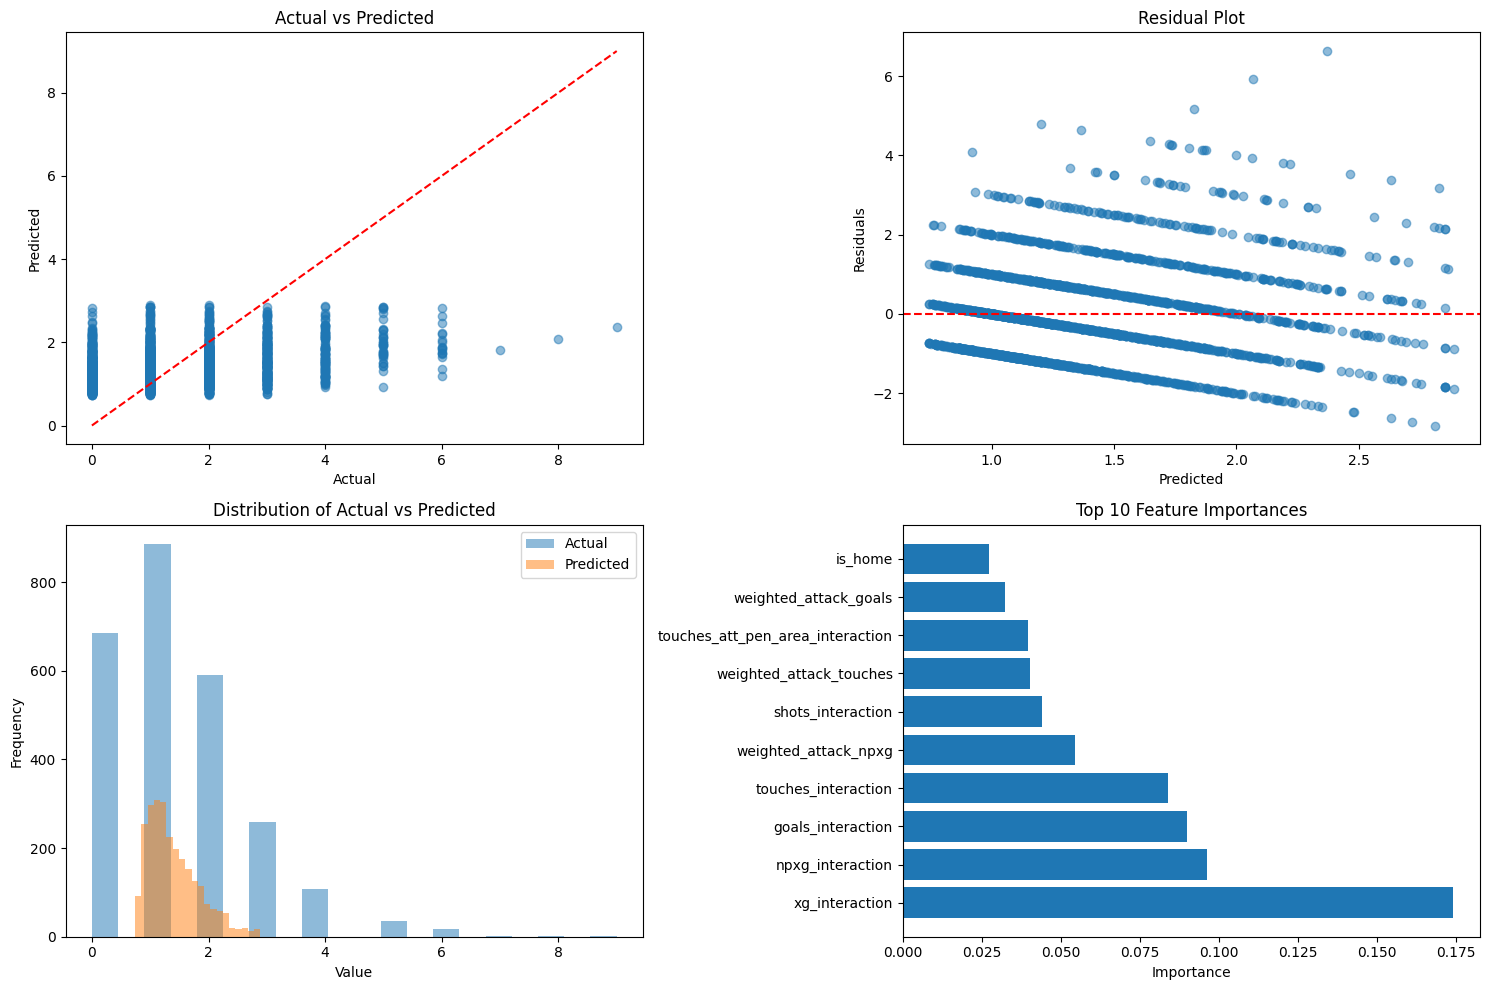

C:\Users\Owner\AppData\Local\Temp\ipykernel_7392\1546311674.py:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_analysis = eval_df.groupby('pred_bin').agg(


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
# Stage 2 best parameters: {'max_depth': 2, 'eta': 0.18, 'subsample': 1.0, 'colsample_bytree': 0.6, 'min_child_weight': 1, 'gamma': 0.19999999999999998, 'reg_alpha': 0, 'reg_lambda': 0.01}
# Get predictions on the test set
y_pred = best_model.predict(X_test)

# Convert to numpy arrays with explicit dtype to ensure compatibility
y_test_np = np.asarray(y_test, dtype=np.float64)
y_pred_np = np.asarray(y_pred, dtype=np.float64)

# Print array types and shapes to debug
print(f"y_test type: {type(y_test)}, shape: {y_test.shape if hasattr(y_test, 'shape') else 'no shape'}")
print(f"y_test_np type: {type(y_test_np)}, shape: {y_test_np.shape}, dtype: {y_test_np.dtype}")
print(f"y_pred_np type: {type(y_pred_np)}, shape: {y_pred_np.shape}, dtype: {y_pred_np.dtype}")

# Basic regression metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test_np, y_pred_np)
rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
r2 = r2_score(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Let's try another approach for calculating Poisson log-likelihood
print("\nCalculating Poisson metrics...")

# Ensure positive predictions
y_pred_np = np.maximum(y_pred_np, 1e-6)

# A simpler version of Poisson deviance (using numpy operations only)
deviance = 0
nll = 0

# Calculate manually element by element to avoid any data type issues
for i in range(len(y_test_np)):
    # Get individual values (definitely scalars)
    y_true_i = float(y_test_np[i])
    y_pred_i = float(y_pred_np[i])
    
    # Calculate log-factorial using loggamma
    from scipy.special import loggamma
    log_factorial = loggamma(y_true_i + 1)
    
    # Calculate components
    if y_true_i > 0:
        component = y_pred_i - y_true_i * np.log(y_pred_i) + log_factorial
    else:
        # When y_true is 0, y_true * log(y_pred) is 0
        component = y_pred_i + log_factorial
    
    deviance += 2 * component
    nll += component

# Average the NLL
nll /= len(y_test_np)

print(f"Poisson Deviance: {deviance:.4f}")
print(f"Poisson Negative Log-Likelihood: {nll:.4f}")

# Calculate calibration (average predicted vs average actual)
print(f"Average actual: {np.mean(y_test_np):.4f}")
print(f"Average predicted: {np.mean(y_pred_np):.4f}")
print(f"Ratio (pred/actual): {np.mean(y_pred_np)/np.mean(y_test_np):.4f}")

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Quick plots
plt.figure(figsize=(15, 10))

# Plot 1: Actual vs Predicted
plt.subplot(2, 2, 1)
plt.scatter(y_test_np, y_pred_np, alpha=0.5)
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

# Plot 2: Residuals
plt.subplot(2, 2, 2)
residuals = y_test_np - y_pred_np
plt.scatter(y_pred_np, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Plot 3: Distribution of Actual vs Predicted
plt.subplot(2, 2, 3)
plt.hist(y_test_np, bins=20, alpha=0.5, label='Actual')
plt.hist(y_pred_np, bins=20, alpha=0.5, label='Predicted')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Actual vs Predicted')

# Plot 4: Feature importances
plt.subplot(2, 2, 4)
n_features = 10  # Number of top features to display
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False).head(n_features)

plt.barh(range(n_features), importances['Importance'], align='center')
plt.yticks(range(n_features), importances['Feature'])
plt.xlabel('Importance')
plt.title(f'Top {n_features} Feature Importances')

plt.tight_layout()
plt.show()

# Evaluate performance by binning predictions
# Create a DataFrame from numpy arrays for easier binning
import pandas as pd
eval_df = pd.DataFrame({
    'actual': y_test_np,
    'predicted': y_pred_np
})

# Define bins for analysis
bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, float('inf')]
bin_labels = ['0-0.5', '0.5-1', '1-1.5', '1.5-2', '2-2.5', '2.5-3', '3-4', '4-5', '5+']

# Bin predictions
eval_df['pred_bin'] = pd.cut(eval_df['predicted'], bins=bins, labels=bin_labels)

# Group by prediction bin and calculate metrics
bin_analysis = eval_df.groupby('pred_bin').agg(
    count=('actual', 'count'),
    avg_actual=('actual', 'mean'),
    avg_predicted=('predicted', 'mean'),
    mae=('actual', lambda x: mean_absolute_error(x, eval_df.loc[x.index, 'predicted'])),
    ratio=('actual', lambda x: np.mean(x) / np.mean(eval_df.loc[x.index, 'predicted']))
).reset_index()

print("\nPerformance by prediction bin:")
print(bin_analysis)

### Error Analysis

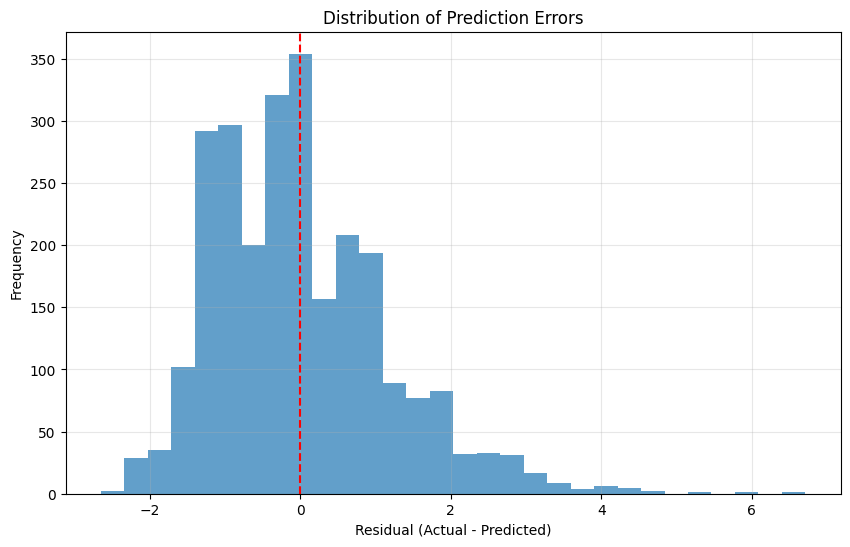

Mean error: 0.0015
Median error: -0.1379
Standard deviation of errors: 1.1644
Percentage of underestimates: 43.49%
Percentage of overestimates: 56.51%


In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals
y_true = dtest.get_label()
y_pred = optimized_model.predict(dtest)
residuals = y_true - y_pred

# Visualize error distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# Calculate error statistics
print(f"Mean error: {np.mean(residuals):.4f}")
print(f"Median error: {np.median(residuals):.4f}")
print(f"Standard deviation of errors: {np.std(residuals):.4f}")
print(f"Percentage of underestimates: {(residuals > 0).mean() * 100:.2f}%")
print(f"Percentage of overestimates: {(residuals < 0).mean() * 100:.2f}%")

Top teams identified: ['Bayern Munich', 'Paris S-G', 'Manchester City', 'Liverpool', 'Leverkusen', 'Dortmund', 'Inter', 'Real Madrid', 'Arsenal', 'Barcelona', 'RB Leipzig', 'Atalanta', 'Tottenham', 'Monaco', 'Atlético Madrid', 'Milan', 'Napoli', 'Marseille', 'Girona', 'Rennes', 'Chelsea', 'Villarreal', 'Newcastle Utd', 'Lyon', 'Stuttgart']

Average Error by Match Type (positive = underprediction, negative = overprediction):
match_type
Other vs Good   -0.116177
Other           -0.024382
Good vs Good     0.016412
Good vs Other    0.190003
Name: error, dtype: float64

Goals by Match Type:
               true_goals  pred_goals     error  pred_ratio
match_type                                                 
Good vs Good     1.627737    1.611326  0.016412    0.989918
Good vs Other    2.056751    1.866748  0.190003    0.907620
Other            1.273632    1.298014 -0.024382    1.019144
Other vs Good    0.963947    1.080124 -0.116177    1.120523


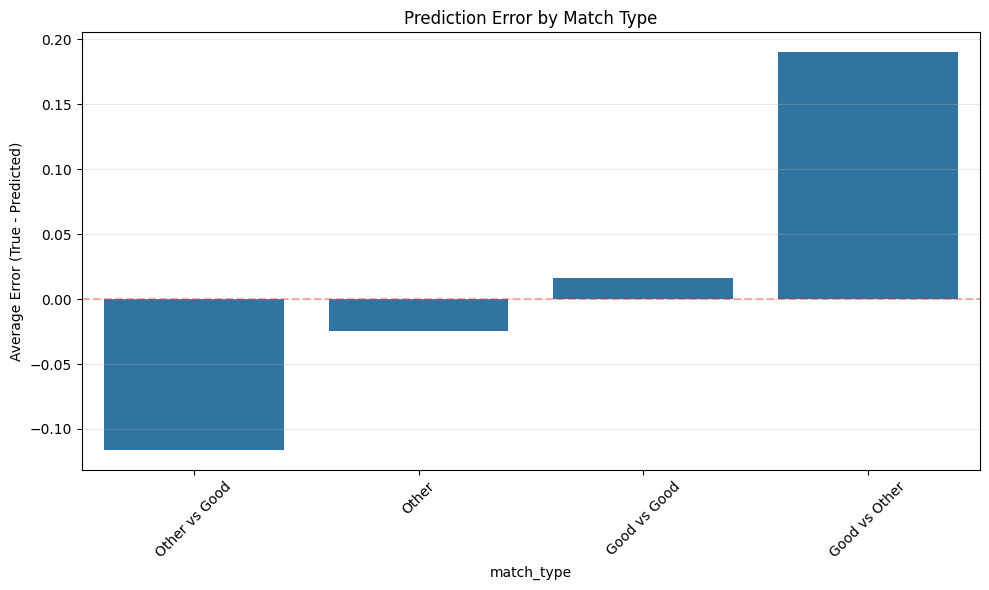

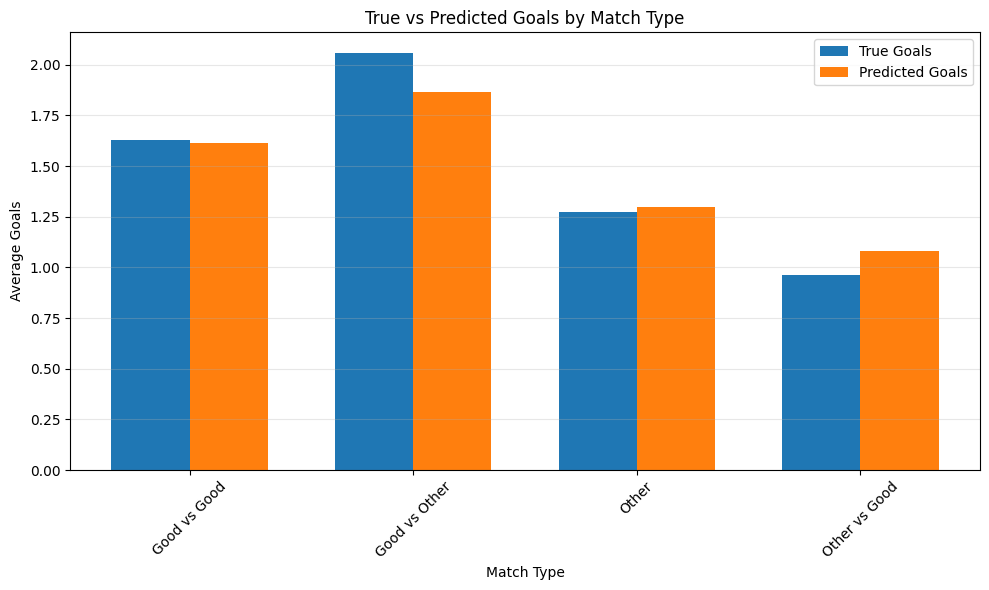

In [ ]:
# Simpler approach with careful type handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Get team information
test_df = df.iloc[X_test.index].copy() if hasattr(X_test, 'index') else df.head(len(X_test)).copy()

# 2. Make sure to convert values to numeric
test_df['true_goals'] = pd.to_numeric(y_test, errors='coerce')
test_df['pred_goals'] = pd.to_numeric(y_pred, errors='coerce')
test_df['error'] = test_df['true_goals'] - test_df['pred_goals']

# 3. Calculate team quality
team_quality = df.groupby('team')['weighted_attack_goals'].mean().sort_values(ascending=False)

# 4. Identify "good" teams (top third)
num_teams = len(team_quality)
top_teams = team_quality.index[:num_teams//5].tolist()
print(f"Top teams identified: {top_teams}")

# 5. Mark matches involving good teams
test_df['good_team'] = test_df['team'].isin(top_teams)
test_df['good_opponent'] = test_df['opp_team'].isin(top_teams)
test_df['both_good'] = test_df['good_team'] & test_df['good_opponent']
test_df['match_type'] = 'Other'
test_df.loc[test_df['both_good'], 'match_type'] = 'Good vs Good'
test_df.loc[(test_df['good_team'] & ~test_df['good_opponent']), 'match_type'] = 'Good vs Other'
test_df.loc[(~test_df['good_team'] & test_df['good_opponent']), 'match_type'] = 'Other vs Good'

# 6. Calculate average error by match type
error_by_match = test_df.groupby('match_type')['error'].mean().sort_values()
print("\nAverage Error by Match Type (positive = underprediction, negative = overprediction):")
print(error_by_match)

# 7. Compare predicted vs actual goals by match type
goals_by_match = test_df.groupby('match_type').agg({
    'true_goals': 'mean',
    'pred_goals': 'mean',
    'error': 'mean'
})
goals_by_match['pred_ratio'] = goals_by_match['pred_goals'] / goals_by_match['true_goals']
print("\nGoals by Match Type:")
print(goals_by_match)

# 8. Simple bar chart showing prediction error by match type
plt.figure(figsize=(10, 6))
sns.barplot(x=error_by_match.index, y=error_by_match.values)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.title('Prediction Error by Match Type')
plt.ylabel('Average Error (True - Predicted)')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 9. Bar chart comparing true vs predicted goals
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(goals_by_match))
plt.bar(index, goals_by_match['true_goals'], bar_width, label='True Goals')
plt.bar(index + bar_width, goals_by_match['pred_goals'], bar_width, label='Predicted Goals')
plt.title('True vs Predicted Goals by Match Type')
plt.xlabel('Match Type')
plt.ylabel('Average Goals')
plt.xticks(index + bar_width/2, goals_by_match.index, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Future Predictions

In [ ]:
def create_team_stats_table(df):
    """
    Create a team stats table adapted to your specific data structure.
    """
    import pandas as pd
    
    # Get the list of all teams
    all_teams = pd.concat([df['team'], df['opp_team']]).unique()
    
    # Create an empty dataframe to store the most recent stats
    team_stats = pd.DataFrame()
    
    # For each team, get their most recent match data (for attack metrics)
    # and also calculate defense metrics from games where they were the opponent
    for team in all_teams:
        # Get attacking metrics from their most recent match as the main team
        team_matches = df[df['team'] == team].sort_values('match_date', ascending=False)
        
        if len(team_matches) > 0:
            most_recent = team_matches.iloc[0].copy()
            
            # Get defensive metrics by looking at matches where they were the opponent
            opp_matches = df[df['opp_team'] == team].sort_values('match_date', ascending=False)
            
            # Create a base dictionary with team info
            stats_dict = {
                'team': team,
                'last_match_date': most_recent['match_date'],
                'last_opponent': most_recent['opp_team'],
                'last_season': most_recent['season']
            }
            
            # Add attacking metrics from their most recent match
            attack_cols = [col for col in df.columns if col.startswith('weighted_attack_')]
            for col in attack_cols:
                stats_dict[col] = most_recent[col]
            
            # Add defensive metrics from matches where they were the opponent
            if len(opp_matches) > 0:
                recent_opp_match = opp_matches.iloc[0]
                
                # The opponent's attacking metrics are this team's defensive metrics
                # Map 'weighted_attack_*' from opponent to 'weighted_defense_*' for this team
                for col in attack_cols:
                    defense_col = col.replace('weighted_attack_', 'weighted_defense_')
                    stats_dict[defense_col] = recent_opp_match[col]
            
            # Add to the team stats dataframe
            team_stats = pd.concat([team_stats, pd.DataFrame([stats_dict])], ignore_index=True)
    
    return team_stats

def predict_match_from_stats_table(model, team_stats, home_team, away_team):
    """
    Predict match result using the trained model and team stats table.
    
    Parameters:
    -----------
    model : trained XGBoost model
        The model to use for prediction
    team_stats : DataFrame
        Table with team statistics
    home_team : str
        Name of the home team
    away_team : str
        Name of the away team
        
    Returns:
    --------
    dict
        Dictionary with prediction results
    """
    # Get most recent matches for each team
    home_recent = df[df['team'] == home_team].sort_values('match_date', ascending=False).iloc[0]
    away_recent = df[df['team'] == away_team].sort_values('match_date', ascending=False).iloc[0]
    
    # Create rows for prediction
    home_row = {'is_home': 1, 'season': home_recent['season']}
    away_row = {'is_home': 0, 'season': away_recent['season']}
    
    # Add attack features (both long-term and form)
    attack_cols = [col for col in df.columns if col.startswith('weighted_attack_') and not col.endswith('_form')]
    form_attack_cols = [col for col in df.columns if col.startswith('weighted_attack_') and col.endswith('_form')]
    
    for col in attack_cols:
        home_row[col] = home_recent[col]
        away_row[col] = away_recent[col]
    
    for col in form_attack_cols:
        if col in home_recent.index and col in away_recent.index:
            home_row[col] = home_recent[col]
            away_row[col] = away_recent[col]
    
    # Get defense features
    # For home team prediction, we need away team's defense
    away_defense = df[df['opp_team'] == away_team].sort_values('match_date', ascending=False)
    # For away team prediction, we need home team's defense
    home_defense = df[df['opp_team'] == home_team].sort_values('match_date', ascending=False)
    
    if len(away_defense) > 0:
        away_defense = away_defense.iloc[0]
    else:
        away_defense = df.mean()  # Fallback to averages
    
    if len(home_defense) > 0:
        home_defense = home_defense.iloc[0]
    else:
        home_defense = df.mean()  # Fallback to averages
    
    # Add defense features (both long-term and form)
    defense_cols = [col for col in df.columns if col.startswith('opp_weighted_defense_opp_') and not col.endswith('_form')]
    form_defense_cols = [col for col in df.columns if col.startswith('opp_weighted_defense_opp_') and col.endswith('_form')]
    
    for col in defense_cols:
        home_row[col] = away_defense[col]
        away_row[col] = home_defense[col]
    
    for col in form_defense_cols:
        if col in away_defense.index and col in home_defense.index:
            home_row[col] = away_defense[col]
            away_row[col] = home_defense[col]
    
    # Calculate gap and ratio features for both long-term and form metrics
    for suffix in ['', '_form']:
        metrics = [col.replace('weighted_attack_', '').replace(suffix, '') 
                  for col in home_row.keys() 
                  if col.startswith('weighted_attack_') and col.endswith(suffix)]
        
        for metric in metrics:
            attack_col = f'weighted_attack_{metric}{suffix}'
            defense_col = f'opp_weighted_defense_opp_{metric}{suffix}'
            
            if attack_col in home_row and defense_col in home_row:
                # Gap features
                home_row[f'{metric}_gap{suffix}'] = home_row[attack_col] - home_row[defense_col]
                away_row[f'{metric}_gap{suffix}'] = away_row[attack_col] - away_row[defense_col]
                
                # Ratio features
                if home_row[defense_col] != 0:
                    home_row[f'{metric}_ratio{suffix}'] = home_row[attack_col] / home_row[defense_col]
                else:
                    home_row[f'{metric}_ratio{suffix}'] = 1
                
                if away_row[defense_col] != 0:
                    away_row[f'{metric}_ratio{suffix}'] = away_row[attack_col] / away_row[defense_col]
                else:
                    away_row[f'{metric}_ratio{suffix}'] = 1
                    
                # Add interaction terms
                home_row[f'{metric}_interaction{suffix}'] = home_row[attack_col] * home_row[defense_col]
                away_row[f'{metric}_interaction{suffix}'] = away_row[attack_col] * away_row[defense_col]
    
    # Create prediction DataFrame
    prediction_df = pd.DataFrame([home_row, away_row])
    
    # Convert season to category codes if it's a string
    if isinstance(prediction_df['season'].iloc[0], str):
        prediction_df['season'] = prediction_df['season'].astype('category').cat.codes
    
    # Ensure all model features are present
    # For XGBRegressor, the feature names attribute is feature_names_in_
    if hasattr(model, 'feature_names_in_'):
        model_features = model.feature_names_in_
    else:
        # Fallback to X_train columns if feature_names_in_ is not available
        model_features = X_train.columns
    
    for feature in model_features:
        if feature not in prediction_df.columns:
            prediction_df[feature] = 0
    
    # Select only the features needed by the model
    prediction_df = prediction_df[model_features]
    
    # Make predictions
    # Check if the model has a predict method (standard sklearn/XGBoost models)
    goal_predictions = model.predict(prediction_df)
    
    # Return results
    return {
        'match': f"{home_team} vs {away_team}",
        'predicted_home_goals': goal_predictions[0],
        'predicted_away_goals': goal_predictions[1],
        'predicted_result': f"{round(goal_predictions[0])}-{round(goal_predictions[1])}",
        'home_advantage': f"{goal_predictions[0] - goal_predictions[1]:.2f} goals"
    }

# Create team stats table
team_stats = create_team_stats_table(df)

# Make prediction for Newcastle vs Chelsea
result = predict_match_from_stats_table(best_model, team_stats, "Wolves", 'Brighton')
print(result)

{'match': 'Wolves vs Brighton', 'predicted_home_goals': 1.4085689, 'predicted_away_goals': 1.6117486, 'predicted_result': '1-2', 'home_advantage': '-0.20 goals'}
